In [98]:
# importing required packages

# packages for data manipulation
import pandas as pd
import numpy as np

# packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(20,5))

# calculating the derivative
import ruptures as rpt

# packages to ignore warnings 
import warnings
warnings.filterwarnings('ignore')

<Figure size 1440x360 with 0 Axes>

# 0. Data Acquisition

For this analysis we are going to be using the following three dataset - 

1. The RAW_us_confirmed_cases.csv file from the Kaggle repository of John Hopkins University COVID-19 data.
2. The CDC dataset of masking mandates by county. *Note that the CDC stopped collecting this policy information in September 2021.*
3. The New York Times mask compliance survey data. 

The majority of this data is by US County by Day. The mask compliance is a single shot estimator that gives you a compliance estimate for every County in the US. 

Finally, for this analysis I will just be focusing on the `Middlesex` country in the state of `Massachusetts`.

## 0.0. Data 1

This data is a time series data of the confirmed Covid cases reported daily. 

In [2]:
# fetching RAW_us_confirmed_cases.csv
us_confirmed_cases = pd.read_csv('data\RAW_us_confirmed_cases.csv')

# filtering the dataset for middlesex county
middlesex_confirmed_cases = us_confirmed_cases[(us_confirmed_cases['Admin2'] == 'Middlesex') & (us_confirmed_cases['Province_State'] == 'Massachusetts')]
middlesex_confirmed_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22
1274,Massachusetts,Middlesex,84025017,US,USA,840,25017.0,US,42.486077,-71.390492,...,410737,410737,410737,412305,412305,412305,412305,412305,412305,412305


As we can see above all of the data is in a single row, so we will need to perform data transformation, so that we have out time series structured as required.

The initial columns of the data contains the information about the middlesex county and the rest is the time series so we will split the data into `general_info` and `confirmed_cases`.

In [3]:
# first 12 columns are general info about the state 
middlesex_general_info = middlesex_confirmed_cases[middlesex_confirmed_cases.columns[0:12]]

# this is useful later
MASSACHUSETTS_FIPS = middlesex_confirmed_cases["FIPS"].values[0]

# confirmed cases time series 
middlesex_cases =  middlesex_confirmed_cases[middlesex_confirmed_cases.columns[12:]]
middlesex_cases = pd.DataFrame(middlesex_cases.iloc[0])
middlesex_cases = middlesex_cases.reset_index()
middlesex_cases.columns = ["date", "cases"]
middlesex_cases.head()

,date,cases
0,1/23/20,0
1,1/24/20,0
2,1/25/20,0
3,1/26/20,0
4,1/27/20,0


## 0.1. Data 2

This dataset provides the mask use by county.

In [4]:
# fetching mask mandate data by county
mask_use_by_county = pd.read_csv('data\mask-use-by-county.csv')
mask_use_by_county.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


The above data is for all the US counties. As I mentioned previously, we are focusing this analysis for the middlesex county. So filtering the data for the middlesex county.

In [5]:
# filtering for middlesex county in Massachusetts
MA_mask_use = mask_use_by_county[mask_use_by_county["COUNTYFP"] == MASSACHUSETTS_FIPS]
MA_mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1225,25017,0.023,0.011,0.041,0.127,0.798


## 0.2. Data 3

This data porovides the mask mandate for each day and for all the US counties.

In [6]:
# fetching mask mandate data
mask_mandates_april20_aug21 = pd.read_csv('data\\U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mask_mandates_april20_aug21.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


Again filtering this for the middlesex county in the state of Massuchusetts.

In [7]:
# filtering for middlesex county in Massachusetts
MA_mask_mandates_april20_aug21 = mask_mandates_april20_aug21[(mask_mandates_april20_aug21["State_Tribe_Territory"] == "MA") &\
     (mask_mandates_april20_aug21['County_Name'] == 'Middlesex County')]
MA_mask_mandates_april20_aug21.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
323093,MA,Middlesex County,25,17,4/14/2020,2,NaN,NaN,NaN,NaN
323184,MA,Middlesex County,25,17,4/15/2020,2,NaN,NaN,NaN,NaN
323214,MA,Middlesex County,25,17,4/16/2020,2,NaN,NaN,NaN,NaN
323244,MA,Middlesex County,25,17,4/17/2020,2,NaN,NaN,NaN,NaN
323307,MA,Middlesex County,25,17,4/18/2020,2,NaN,NaN,NaN,NaN


In [8]:
# unique values in the "Face_Masks_Required_in_Public"
MA_mask_mandates_april20_aug21['Face_Masks_Required_in_Public'].unique()

array([nan, 'Yes', 'No'], dtype=object)

As we can see above that the attribute `Face_Masks_Required_in_Public` have values - Yes, No and NaN. So, lets set NaN values from before mandates came into effect to `NO`. Technically people were not required to wear masks when covid did not exist in the state.

In [9]:
# filling Nan with NO
MA_mask_mandates_april20_aug21["Face_Masks_Required_in_Public"] = MA_mask_mandates_april20_aug21["Face_Masks_Required_in_Public"].fillna("No")

In [ ]:
# since it is a big data, filtering to just get the required columns
mask_requirement = MA_mask_mandates_april20_aug21[['date', 'Face_Masks_Required_in_Public']]
mask_requirement

In [ ]:
# separating the above df to masked and unmasked dataframes
masked = mask_requirement[mask_requirement['Face_Masks_Required_in_Public'] == 'Yes']
unmasked = mask_requirement[mask_requirement['Face_Masks_Required_in_Public'] == 'No']

# 1. Analyze & Visualize

The research question that we are analyzing in this notebook is - 

***How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?***


In [30]:
# setting date as index
middlesex_cases = middlesex_cases.set_index('date')

# calculating the derivative of confirmed cases (difference between consecutive rows)
middlesex_cases["derivative_cases"] = pd.Series(np.gradient(middlesex_cases["cases"]), middlesex_cases.index, name='cases').values

<Figure size 1440x360 with 0 Axes>

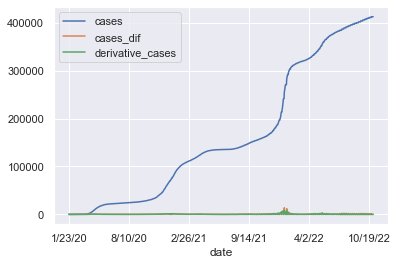

In [37]:
# simple line chart of the covid cases
middlesex_cases.plot()

# defining the labels and title
plt.ylabel('Covid Confirmed cases')
plt.title('Daily confirmed covid cases')

# showing the plot
plt.show()

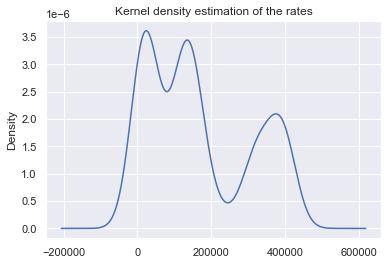

In [70]:
# kde plot to get the density
middlesex_cases['cases'].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [91]:
#masked.date.tail(1)
MASKED_14INTERVAL = (pd.to_datetime(masked.date) + pd.to_timedelta(14,unit='d')).iat[-1].strftime('%d-%m-%y')
UNMASKED_14INTERVAL = (pd.to_datetime(unmasked.date) + pd.to_timedelta(14,unit='d')).iat[-1].strftime('%d-%m-%y')

Text(0, 0.5, 'Daily Cases')

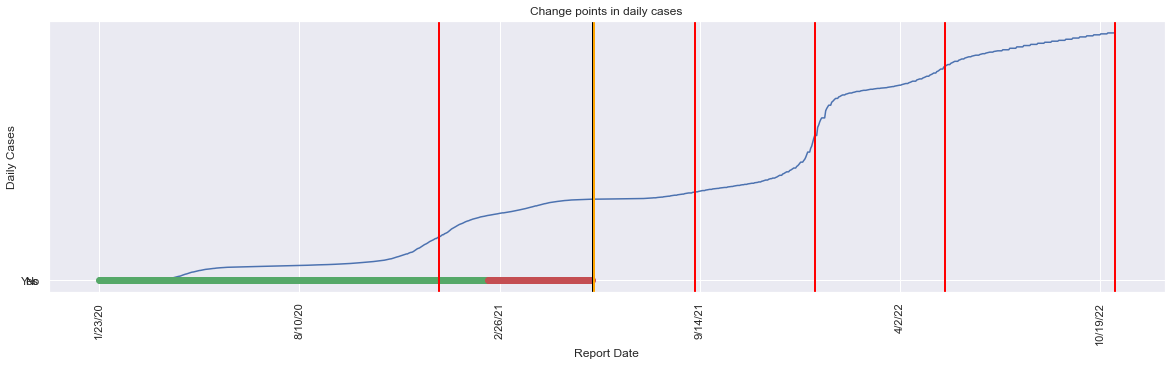

In [97]:
data = np.array(middlesex_cases['cases'])

# detect the changepoints
algo1 = rpt.Pelt(model='rbf').fit(data)
change_location1 = algo1.predict(pen=10)

# plotting the daily confirmed covid cases
middlesex_cases['cases'].plot()

# plotting the days with mask on and off
plt.plot(masked.date, masked.Face_Masks_Required_in_Public, 'go')
plt.plot(unmasked.date, unmasked.Face_Masks_Required_in_Public, 'ro')

# plotting the 14-day interval line after the last mask-on date and mask-off date
plt.axvline(x = MASKED_14INTERVAL, lw = 2, color = 'black')
plt.axvline(x = UNMASKED_14INTERVAL, lw = 2, color = 'orange')

# plotting the changepoints
for x in change_location1:
    plt.axvline(x,lw=2, color='red')

# adding appropriate labels
plt.title('Change points in daily cases')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Daily Cases')

Text(0, 0.5, 'Daily Cases')

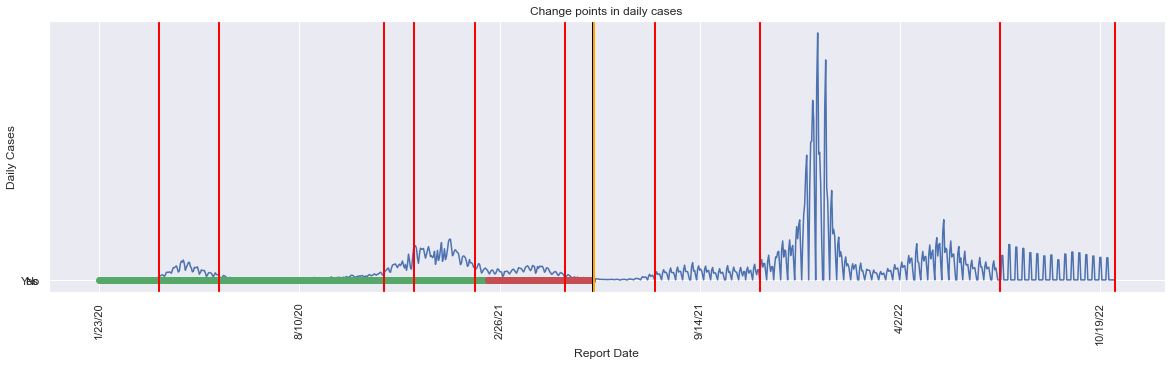

In [95]:
data = np.array(middlesex_cases['derivative_cases'])

# detect the change points
algo1 = rpt.Pelt(model='rbf').fit(data)
change_location1 = algo1.predict(pen=10)

# plotting the daily change in the covid cases
middlesex_cases['derivative_cases'].plot()

# plotting the days with mask on and off
plt.plot(masked.date, masked.Face_Masks_Required_in_Public, 'go')
plt.plot(unmasked.date, unmasked.Face_Masks_Required_in_Public, 'ro')

# plotting the 14-day interval line after the last mask-on date and mask-off date
plt.axvline(x = MASKED_14INTERVAL, lw = 2, color = 'black')
plt.axvline(x = UNMASKED_14INTERVAL, lw = 2, color = 'orange')

# plotting the changepoints
for x in change_location1:
    plt.axvline(x,lw=2, color='red')

# adding appropriate labels
plt.title('Change points in daily change in cases')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Daily change in Cases')